In [1]:
import xarray as xr
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

import functions.eddy_feedback as ef
import functions.data_wrangling as data

## Import data

In [2]:
path = Path('/home/links/ct715/data_storage/isca/regan_sims/polar_vortex')
data_files = sorted(path.glob('*.nc'))

exp_names = []
for item in data_files:
    
    file_stem = item.stem
    exp = file_stem.split('_')[1]
    exp_names.append(exp)

ds = {}
for exp in exp_names:
    
    data_path = path / f'PK_{exp}_mon_uvt_ep.nc'
    
    dataset = xr.open_dataset(str(data_path))
    dataset['ubar'] = dataset['u'].mean('lon')
    # dataset = dataset.sel(time=slice('2002-03', '2041-11'))
    ds[exp] = dataset

In [3]:
efp = {'experiment': [], 'efp': []}

for exp in exp_names:
    efp_value = ef.calculate_efp(ds[exp], data_type='isca')
    efp['experiment'].append(exp)
    efp['efp'].append(efp_value)

df = pd.DataFrame(efp)
df

,experiment,efp
0,e0v1z13,0.1724
1,e0v2z13,0.1803
2,e0v3z13,0.1434
3,e0v4z13,0.2272
4,e0v5z13,0.2138
5,e0v6z13,0.2532


In [4]:
df['neck_wind'] = np.nan
df

,experiment,efp,neck_wind
0,e0v1z13,0.1724,NaN
1,e0v2z13,0.1803,NaN
2,e0v3z13,0.1434,NaN
3,e0v4z13,0.2272,NaN
4,e0v5z13,0.2138,NaN
5,e0v6z13,0.2532,NaN


In [5]:
neck_winds = {}
for exp in exp_names:
    
    ubar = ds[exp].ubar
    ubar = data.seasonal_mean(ubar, season='djf')
    ubar = ubar.mean('time')
    
    u_neck = ubar.sel(level=70, method='nearest').sel(lat=slice(45,55)).mean('lat')
    # neck_winds[exp] = np.mean(u_neck.values).round(3)
    df.loc[df['experiment'] == exp, 'neck_wind'] = np.mean(u_neck.values).round(3)

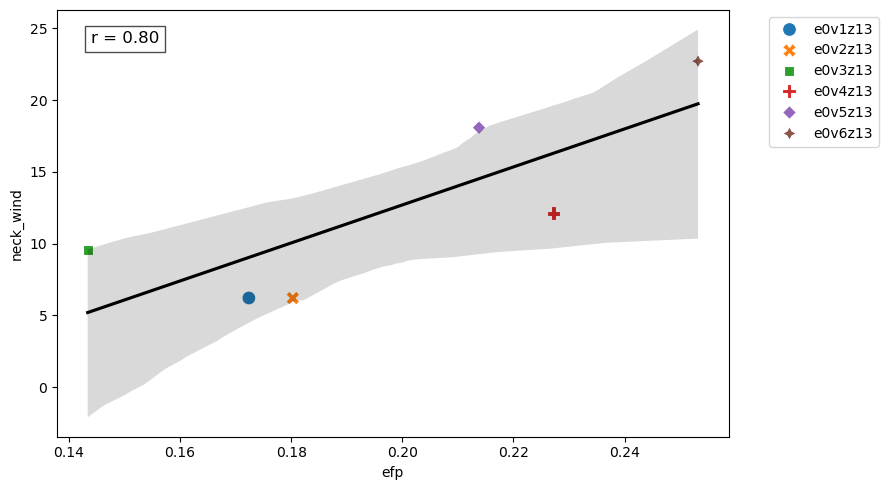

In [6]:
fig, ax = plt.subplots(figsize=(9,5))

# Function to compute and add Pearson correlation
def add_correlation(ax, x, y):
    corr, _ = pearsonr(x, y)  # Compute Pearson correlation
    ax.text(0.05, 0.95, f"r = {corr:.2f}", transform=ax.transAxes, 
            fontsize=12, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))

sns.scatterplot(
    x=df['efp'],
    y=df['neck_wind'],
    hue=df['experiment'],
    style=df['experiment'],
    s=100,
    ax=ax
)
sns.regplot(
    x=df['efp'],
    y=df['neck_wind'],
    scatter=False,
    color='k',
    # ci=None,
    ax=ax
)

# Add correlation to the figure
add_correlation(ax, df['efp'], df['neck_wind'])

# Add legend and adjust layout
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()